In [6]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.read_utils.read_gs_ply_files import convert_to_gaussian_schema, read_ply_file
from splat.utils import read_images_binary, read_images_text

# stem = "/Users/derek/Desktop/intro_to_gaussian_splatting"
stem = "/home/da2986/intro_to_gaussian_splatting"

# models_path = "/Users/derek/Downloads/models/"
models_path = "/home/da2986/intro_to_gaussian_splatting/models"
ply_path = f"/home/da2986/gaussian-splatting/truck/point_cloud/iteration_30000/point_cloud.ply"
# vertices = read_ply_file(ply_path)
gaussians = convert_to_gaussian_schema(vertices)

colmap_path = f"{stem}/data/treehill/sparse/0"
colmap_path = f"/home/da2986/gaussian-splatting/tandt/truck/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

[-0.37234583497047424, -0.41850927472114563, -0.25019344687461853]
tensor([0.3950, 0.3819, 0.4294])


In [7]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntrinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 2
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2] / 2
focal_x = int(focal_x)
focal_y = int(focal_y)
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width / 2
width = int(width)
height = camera_dict[image_dict[image_num].camera_id].height / 2
height = int(height)
intrinsic_matrix = getIntrinsicMatrix(focal_x, focal_y, height, width).T

In [8]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
scene.device = "cuda"
TILE_SIZE = 16

processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    tile_size=TILE_SIZE
)

covariance_2d tensor([[[ 5.2790, -1.3900],
         [-1.3900,  0.7212]]], device='cuda:0')
mid tensor([3.0001], device='cuda:0')
det tensor([1.8751], device='cuda:0')
lambda1, lambda2 tensor([5.6695], device='cuda:0') tensor([0.3307], device='cuda:0')
torch.Size([2, 1289176]) torch.Size([2, 1289176])


In [11]:
with torch.no_grad():
    output_image, starting_indices, final_tile_indices, array_indices, array = scene.render_cuda(
        preprocessed_gaussians=processed_gaussians, height=height, width=width, tile_size=TILE_SIZE
    )
    
from PIL import Image
image = output_image.cpu().numpy() * 255

image = Image.fromarray(image.astype(np.uint8))
image.save("test_output.jpg")

62 35
Number of elements in image tensor: 1599030


In [10]:
array

tensor([[0.0000e+00, 0.0000e+00, 5.4070e-01, 5.6172e+05],
        [0.0000e+00, 0.0000e+00, 6.0092e-01, 1.0830e+06],
        [0.0000e+00, 0.0000e+00, 7.2644e-01, 7.7206e+05],
        ...,
        [6.1000e+01, 3.4000e+01, 5.3939e+00, 7.1937e+05],
        [6.1000e+01, 3.4000e+01, 6.0534e+00, 1.0634e+06],
        [6.1000e+01, 3.4000e+01, 2.7965e+01, 5.2288e+05]], device='cuda:0')

Found 533010 non-zero pixels at coordinates:


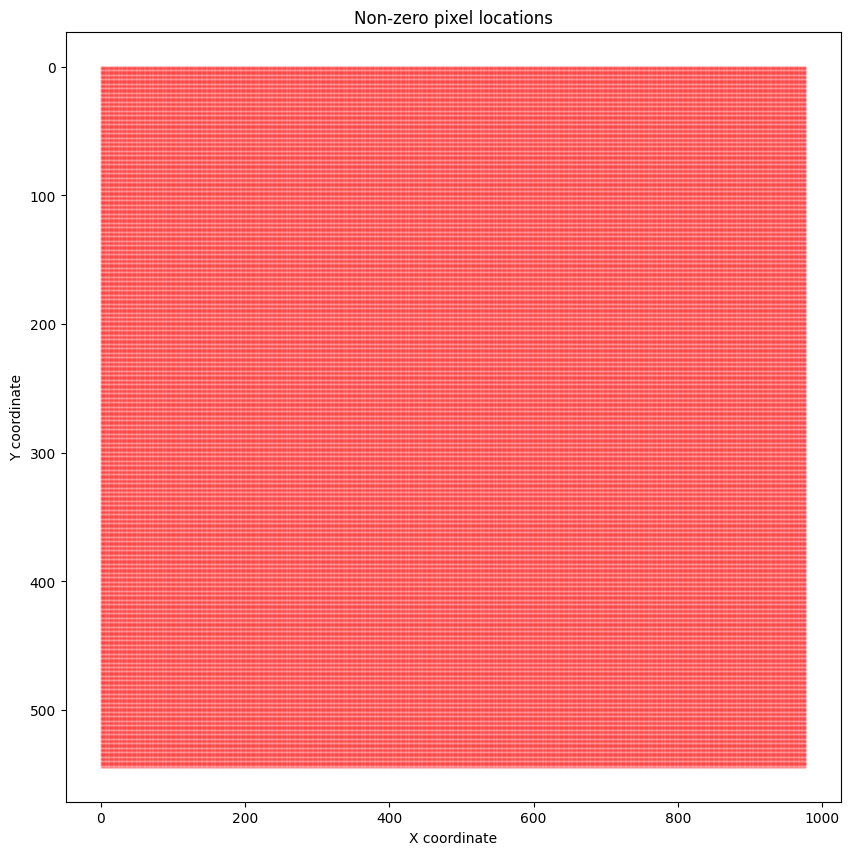

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Convert output image to numpy and find non-zero pixels
image_np = output_image.cpu().numpy()
# sum the third dimension
image_np = np.sum(image_np, axis=2)
nonzero_pixels = np.argwhere(image_np > 1e-3)

print(f"Found {len(nonzero_pixels)} non-zero pixels at coordinates:")
# for y, x in nonzero_pixels:
#     print(f"Position (y={y}, x={x})")

# Optional visualization of non-zero pixel locations
plt.figure(figsize=(10,10))
plt.scatter(nonzero_pixels[:,1], nonzero_pixels[:,0], c='red', s=1, alpha=0.1)
plt.title("Non-zero pixel locations")
plt.xlabel("X coordinate") 
plt.ylabel("Y coordinate")
plt.gca().invert_yaxis() # Invert Y axis to match image coordinates
plt.show()

In [40]:
from PIL import Image

image = output_image.cpu().numpy() * 255
image = Image.fromarray(image.astype(np.uint8))
image.save("test_output.jpg")

In [ ]:
from PIL import Image

image_path = "/Users/derek/Desktop/intro_to_gaussian_splatting/data/treehill/images/_DSC8973.JPG"
image = Image.open(image_path)

plt.imshow(image)
plt.show()